LIBRARIES

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings
from scipy.stats import ttest_ind, chi2_contingency, pearsonr, spearmanr, f_oneway, sem, norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder

warnings.simplefilter(action='ignore', category=FutureWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FUNCTIONS 

In [8]:
def load_and_preprocess_data(filepath1, filepath2):
    
    # Load the two datasets
    df1 = pd.read_excel(filepath1)
    df2 = pd.read_excel(filepath2)

    df2 = df2.rename(columns={'ID code': 'ID CODE'})

    del df2['Dressing type']

    # Merge the two datasets based on the ID code column
    df = pd.merge(df1, df2, on="ID CODE")

    del df['ID CODE']
    del df['Baseline visit']

    # Round the columns to 2 decimal places
    cols_to_save = ['porc_postural changes', 'porc_friccion', 'porc_infec']
    df[cols_to_save] = df[cols_to_save].round(2)

    # Print the number of observations in the dataset
    print("Number of observations:", len(df))

    # Print the number of missing values in the dataset
    print("Number of missing values:")
    print(df.isnull().sum())

    return df

def visualize_correlation_matrix(df):
    
    corr_matrix = df.corr(method='spearman')

    # Generate heatmap plot with lower triangle mask
    plt.figure(figsize=(20, 16))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmin=-1, vmax=1, mask=mask)
    plt.title('Correlation Matrix')
    plt.show()


def plot_percentage_still_in_study(df, feature_name):

    # Group the data by target feature and number of visits for patients with Ulcer_stage = 1 and get the counts
    grouped = df[df['Ulcer_stage'] == 1].groupby([feature_name, 'num. visit']).size().reset_index(name='counts')
    
    # Get the counts and percentages for patients with target feature = 0
    feature_0 = grouped[grouped[feature_name] == 0].reset_index(drop=True)
    feature_0_percentages = [feature_0.loc[feature_0['num. visit'] >= i, 'counts'].sum() / feature_0['counts'].sum() * 100 for i in range(9)]
    
    # Get the counts and percentages for patients with target feature = 1
    feature_1 = grouped[grouped[feature_name] == 1].reset_index(drop=True)
    feature_1_percentages = [feature_1.loc[feature_1['num. visit'] >= i, 'counts'].sum() / feature_1['counts'].sum() * 100 for i in range(9)]
    
    # Convert the percentages to numpy arrays
    feature_0_percentages = np.array(feature_0_percentages)
    feature_1_percentages = np.array(feature_1_percentages)
    
    # Calculate standard errors and confidence intervals for target feature = 0
    feature_0_se = np.sqrt(feature_0_percentages * (100 - feature_0_percentages) / feature_0['counts'].sum())
    feature_0_ci = 1.96 * feature_0_se
    
    # Calculate standard errors and confidence intervals for target feature = 1
    feature_1_se = np.sqrt(feature_1_percentages * (100 - feature_1_percentages) / feature_1['counts'].sum())
    feature_1_ci = 1.96 * feature_1_se
    
    # Create a plot with confidence intervals for both target feature values
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, 9), feature_0_percentages, label=feature_name + ' 0')
    plt.fill_between(range(0, 9), feature_0_percentages - feature_0_ci, feature_0_percentages + feature_0_ci, alpha=0.2)
    plt.plot(range(0, 9), feature_1_percentages, label=feature_name + ' 1')
    plt.fill_between(range(0, 9), feature_1_percentages - feature_1_ci, feature_1_percentages + feature_1_ci, alpha=0.2)
    
    # Set the x and y axis labels and limits, add a legend, and plot the 50% mark and its corresponding week for both feature values
    plt.xlabel('Week')
    plt.ylabel('Percentage of patients still in study')
    plt.ylim(0, 100)
    plt.legend()

    # Calculate the week at which 50% of patients are still in the study for target feature = 0, and plot a vertical and horizontal line at that point
    x_0 = np.interp(50, np.flip(feature_0_percentages), np.flip(range(0, 9)))
    y_0 = 50
    plt.plot([0, x_0], [y_0, y_0], color='black', linestyle='--')
    plt.plot([x_0, x_0], [y_0, 0], color='black', linestyle='--')

    # Calculate the week at which 50% of patients are still in the study for target feature = 1, and plot a vertical and horizontal line at that point
    x_1 = np.interp(50, np.flip(feature_1_percentages), np.flip(range(0, 9)))
    y_1 = 50
    plt.plot([0, x_1], [y_1, y_1], color='black', linestyle='--')
    plt.plot([x_1, x_1], [y_1, 0], color='black', linestyle='--')

    # Show the plot
    plt.show()

    # Calculate the standard error for each point
    feature_0_se = np.sqrt(feature_0_percentages * (100 - feature_0_percentages) / feature_0['counts'].sum())
    feature_1_se = np.sqrt(feature_1_percentages * (100 - feature_1_percentages) / feature_1['counts'].sum())

    # Initialize empty lists to store confidence intervals
    feature_0_ci_list = []
    feature_1_ci_list = []
    
    # Calculate the confidence interval for each point (using a 95% confidence level)
    feature_0_ci = 1.96 * feature_0_se
    feature_1_ci = 1.96 * feature_1_se

    # Print the confidence interval for each point
    print(f"{feature_name} 0 confidence intervals:")
    for i in range(9):
      lower_bound = feature_0_percentages[i] - feature_0_ci[i]
      upper_bound = feature_0_percentages[i] + feature_0_ci[i]
      if upper_bound > 100:
        upper_bound = 100
      if lower_bound <0:
        lower_bound = 0
      print(f"Week {i}: [{lower_bound:.2f}, {upper_bound:.2f}]")
      feature_0_ci_list.append([lower_bound, upper_bound])

    print(f"\n{feature_name} 1 confidence intervals:")
    for i in range(9):
      lower_bound = feature_1_percentages[i] - feature_1_ci[i]
      upper_bound = feature_1_percentages[i] + feature_1_ci[i]
      if upper_bound > 100:
        upper_bound = 100
      if lower_bound <0:
        lower_bound = 0
      print(f"Week {i}: [{lower_bound:.2f}, {upper_bound:.2f}]")
      feature_1_ci_list.append([lower_bound, upper_bound])

    # Print the x value associated with 50% y-axis 
    print(f"\n{feature_name} 0 x value for 50% y-axis: {x_0:.2f}")
    print(f"{feature_name} 1 x value for 50% y-axis: {x_1:.2f}")
    print("\n")

    for i in range(len(feature_0_ci_list)):
      ci_0 = feature_0_ci_list[i]
      ci_1 = feature_1_ci_list[i]
    
    # Calculate the midpoint and the margin of error for each confidence interval
      midpoint_0 = sum(ci_0) / 2
      margin_0 = (ci_0[1] - ci_0[0]) / 2
    
      midpoint_1 = sum(ci_1) / 2
      margin_1 = (ci_1[1] - ci_1[0]) / 2
    
    # Calculate the test statistic and p-value using the two-sample t-test
      t_stat, p_val = stats.ttest_ind_from_stats(midpoint_0, margin_0, len(ci_0), midpoint_1, margin_1, len(ci_1), equal_var=True)
    
    # Print the results
      print(f"Week {i}:")
      print(f"T-statistic: {t_stat}")
      print(f"P-value: {p_val}")
      if p_val > 0.10 or np.isnan(p_val):
        print("Not significant")
      else:
        print("Significant")


def divide_columns(df):
    
    columns = list(df.columns)
    unique_counts = []
    for column in columns:
        unique_counts.append(len(set(df[column])))

    # Dividing columns into binary, discrete or continuous
    binary_columns = []
    discrete_columns = []
    continuous_columns = []
    for i, column in enumerate(columns):
        if unique_counts[i] == 2:
            binary_columns.append(column)        
        elif unique_counts[i] <= 8:
            discrete_columns.append(column)
        else:
            continuous_columns.append(column)

    print("Binary columns:", binary_columns)
    print("Discrete columns:", discrete_columns)
    print("Continuous columns:", continuous_columns)
    
    return binary_columns, discrete_columns, continuous_columns


def visualize_binary_columns(binary_columns, target_feature):

    for column in binary_columns:
        cross_tab = pd.crosstab(df[target_feature], df[column])
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        print(column + ": chi-squared p-value = " + str(p))
        sns.countplot(x=column, hue=target_feature, data=df)
        plt.show()


def visualize_discrete_columns(discrete_columns, target_feature):

    for column in discrete_columns:
        cross_tab = pd.crosstab(df[target_feature], df[column])
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        print(column + ": chi-squared p-value = " + str(p))
        cross_tab.plot(kind='bar', stacked=True)
        plt.legend(title=column, loc="best", labels=df[column].unique())
        plt.show()


def visualize_continuous_columns(continuous_columns, target_feature):

    colors = {0: 'tab:blue', 1: (1.0, 0.84, 0.0)}

    for col in continuous_columns:
        plt.figure(figsize=(12,8))

        # Remove outliers using IQR method
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        df_filtered = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        # Check for normality using the Shapiro-Wilk test
        normal = True
        shapiro_results = stats.shapiro(df_filtered[col])
        p_value = shapiro_results[1]
        if p_value < 0.10:
            normal = False

        # Choose the appropriate test based on normality
        if normal:
            test = stats.ttest_ind
            test_name = 't-test'
        else:
            test = stats.mannwhitneyu
            test_name = 'Mann-Whitney U test'

        ax = sns.boxplot(x=target_feature, y=col, data=df_filtered, palette=colors)
        plt.title(f"{col} by {target_feature}")
        plt.xlabel(target_feature)
        plt.ylabel(col)
        group0 = df_filtered[df_filtered[target_feature] == 0][col]
        group1 = df_filtered[df_filtered[target_feature] == 1][col]
        p_value = test(group0, group1)[1]
        ax.text(0.95, 0.95, f'p-value: {p_value:.4f}', transform=ax.transAxes, ha='right', va='top', fontsize=12)
        print(f"{col} Shapiro-Wilk test results: W = {shapiro_results[0]:.4f}, p-value = {shapiro_results[1]:.4f}")
        print(f"{col} {test_name} p-value: {p_value:.4f}\n")
        plt.show()


def encode_data(df):

    df = df.fillna(0)

    # Map categorical variables to numerical values
    braden_scale_map = {'Sin riesgo': 0, 'Riesgo bajo': 1, 'Riesgo moderado': 2, 'Riesgo alto': 3}
    df['Braden Scale'] = df['Braden Scale'].replace(braden_scale_map)

    sex_map = {'Male': 0, 'Female': 1}
    df['Sex'] = df['Sex'].replace(sex_map)

    dressing_type_map = {'Hydrocellular': 0, 'Hydrocolloid': 1}
    df['Dressing type'] = df['Dressing type'].replace(dressing_type_map)

    cured_map = {1: 1, 2: 0}
    df['Cured: 1, no cured: 2'] = df['Cured: 1, no cured: 2'].replace(cured_map)

    infected_map = {1: 1, 2: 0}
    df['infected'] = df['infected'].replace(infected_map)

    loss_map = {1: 1, 2: 0} 
    df['Loss to follow up'] = df['Loss to follow up'].replace(loss_map)

    # OneHotEncoder
    onehotencoder = OneHotEncoder()
    location_encoded = onehotencoder.fit_transform(df[['Location']]).toarray()
    location_encoded_df = pd.DataFrame(location_encoded, columns=onehotencoder.get_feature_names_out(['Location']))

    # Concatenate the location_encoded_df dataframe with the original df
    df = pd.concat([df, location_encoded_df], axis=1)
    del df['Location']

    return df


def cluster_analysis(df, target_feature):

    # Select the feature to cluster on
    X = df[[target_feature]]

    # Preprocess the df (normalize the df)
    X = (X - X.mean()) / X.std()

    # Initialize WCSS list and number of clusters range
    wcss = []
    k_range = range(1, 11)

    # Apply Clusters with K algorithm for each k value and compute WCSS
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Plot the WCSS values against the number of clusters
    plt.plot(k_range, wcss)
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.show()

    # Compute the silhouette scores for each k value
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        if kmeans.n_clusters > 1:
            labels = kmeans.labels_
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(-1)  # assign a negative score if only 1 cluster

    # Plot the silhouette scores against the number of clusters
    plt.plot(k_range, silhouette_scores)
    plt.title("Silhouette Analysis")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

    # Create 2 clusters using KMeans algorithm
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(X)

    df['Cluster'] = kmeans.labels_
    cluster_counts = df['Cluster'].value_counts()
    print("Counts of unique clusters:")
    print(cluster_counts)
    
    return df


STATISTICAL ANALYSIS

Number of observations: 169
Number of missing values:
Nurse costs               0
Dressing costs           12
Material costs            0
Secondary costs           0
Total costs               0
Dressing type             0
Sex                       0
Age                       0
num. visit                1
Ulcer_stage               0
Cured: 1, no cured: 2     0
infected                  0
Postural changes          0
red_friccion              0
Avoided_infecion          0
Braden Scale              0
Push Scale                0
porc_postural changes    44
porc_friccion            44
porc_infec               44
Loss to follow up         0
Location                  0
dtype: int64


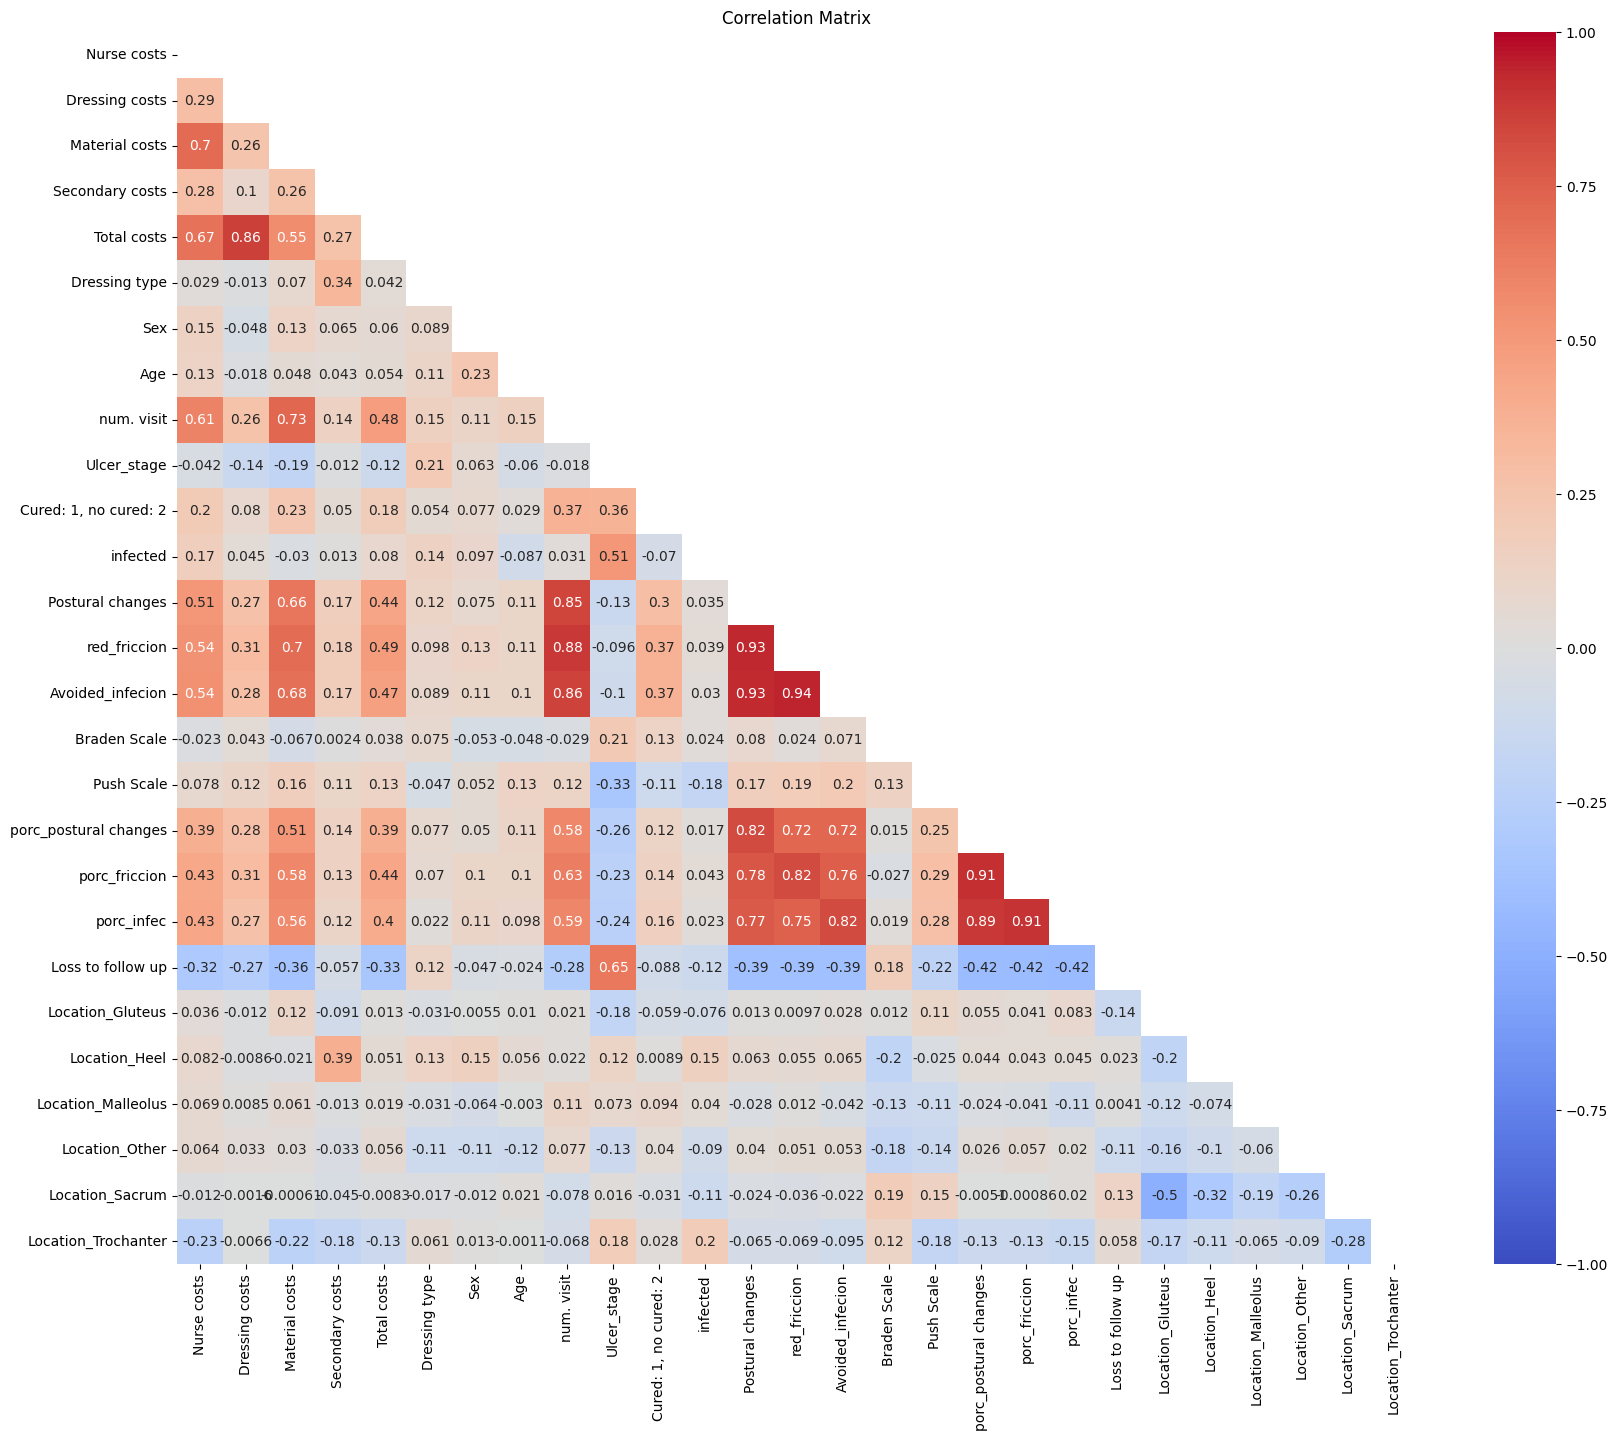

Binary columns: ['Dressing type', 'Sex', 'Ulcer_stage', 'Cured: 1, no cured: 2', 'infected', 'Loss to follow up', 'Location_Gluteus', 'Location_Heel', 'Location_Malleolus', 'Location_Other', 'Location_Sacrum', 'Location_Trochanter']
Discrete columns: ['num. visit', 'Postural changes', 'red_friccion', 'Avoided_infecion', 'Braden Scale', 'porc_postural changes', 'porc_friccion', 'porc_infec']
Continuous columns: ['Nurse costs', 'Dressing costs', 'Material costs', 'Secondary costs', 'Total costs', 'Age', 'Push Scale']
Dressing type: chi-squared p-value = 9.040029637657744e-38


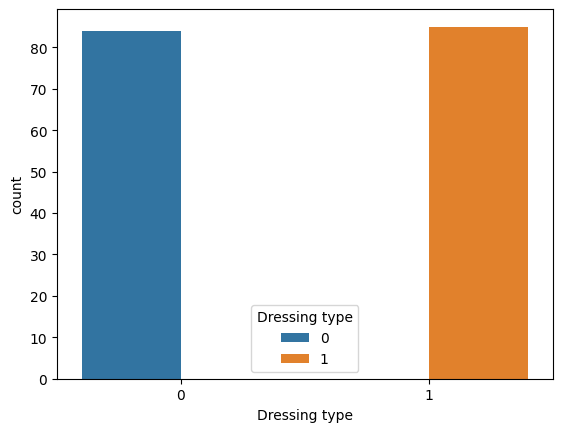

Sex: chi-squared p-value = 0.3170299489594891


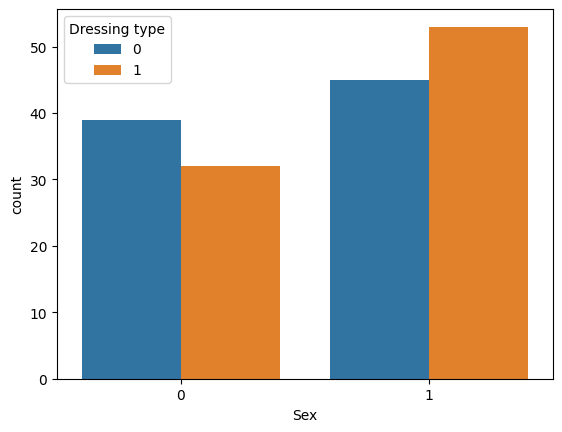

Ulcer_stage: chi-squared p-value = 0.01091496251106863


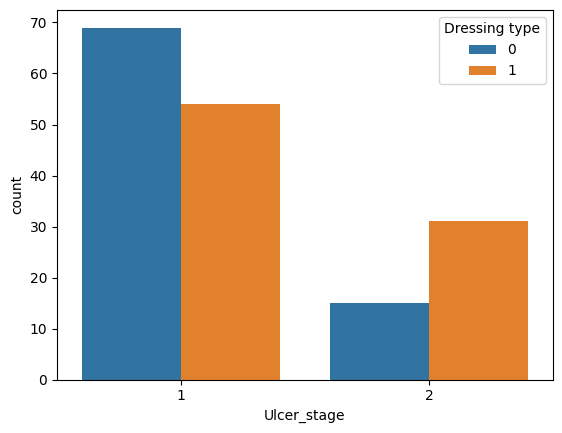

Cured: 1, no cured: 2: chi-squared p-value = 0.7300268181279722


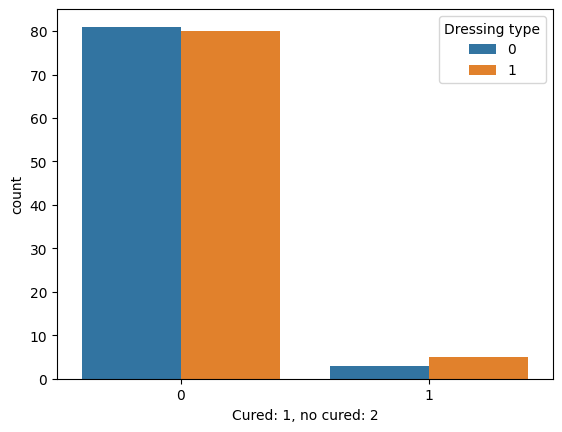

infected: chi-squared p-value = 0.10984082239290303


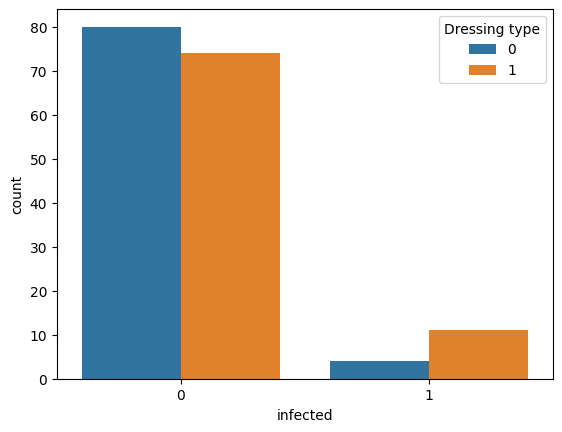

Loss to follow up: chi-squared p-value = 0.188335094192469


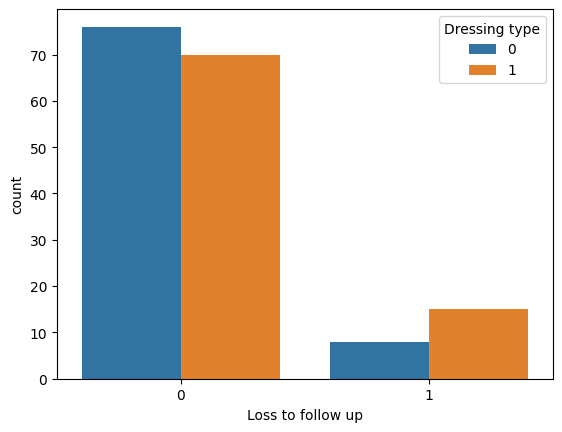

Location_Gluteus: chi-squared p-value = 0.8229026626427688


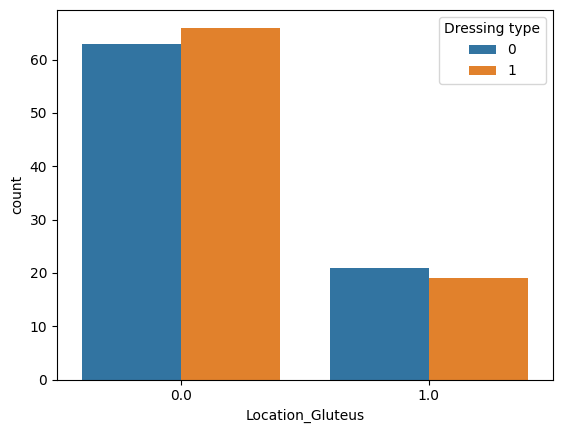

Location_Heel: chi-squared p-value = 0.15165165661932142


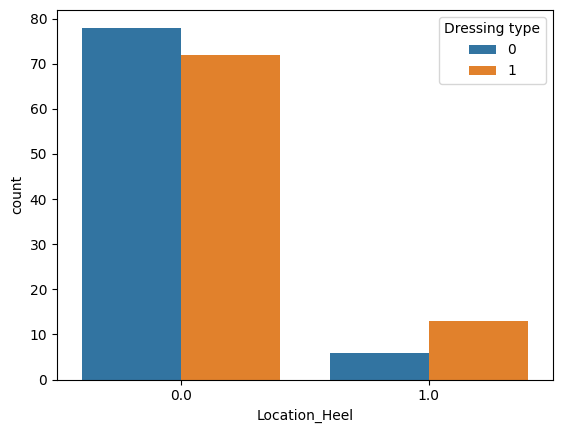

Location_Malleolus: chi-squared p-value = 0.9872421551030677


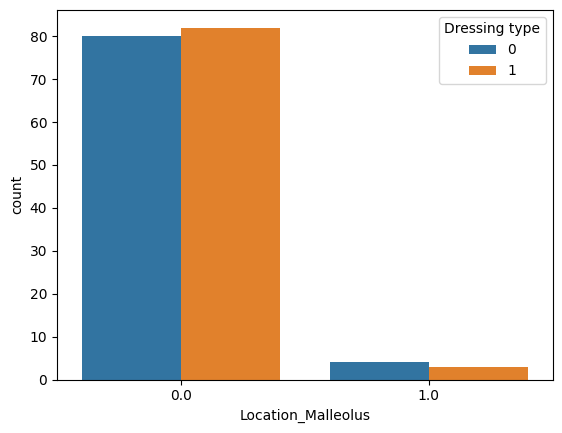

Location_Other: chi-squared p-value = 0.23922467553238946


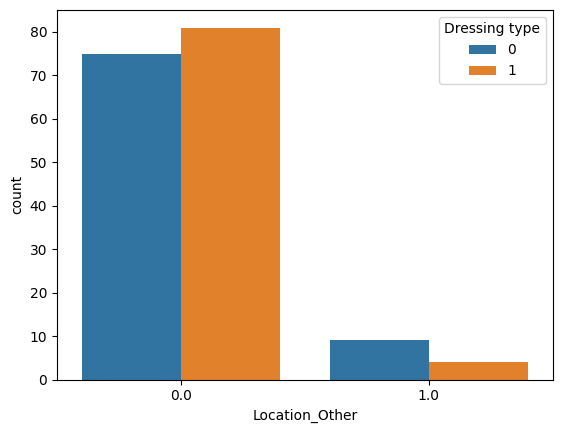

Location_Sacrum: chi-squared p-value = 0.9452190719583906


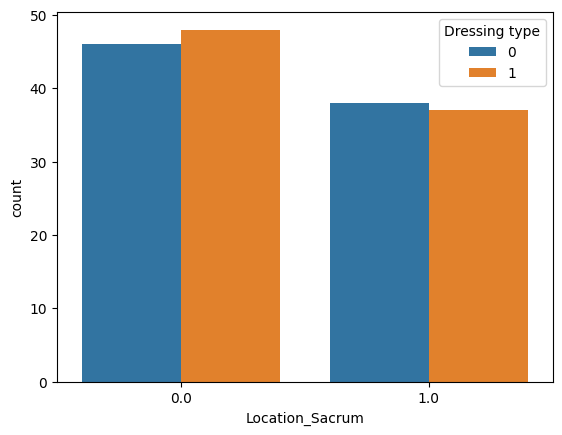

Location_Trochanter: chi-squared p-value = 0.6051808889640098


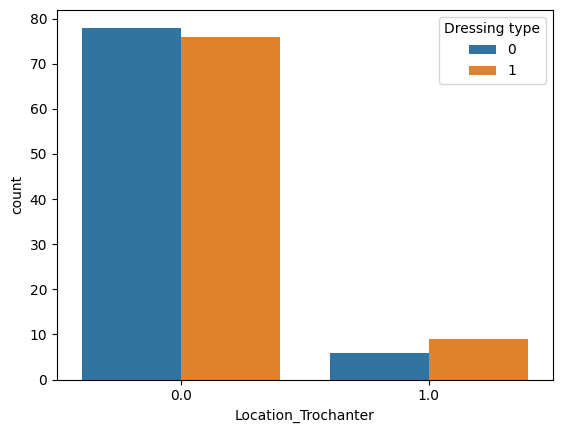

num. visit: chi-squared p-value = 0.4496801934896243


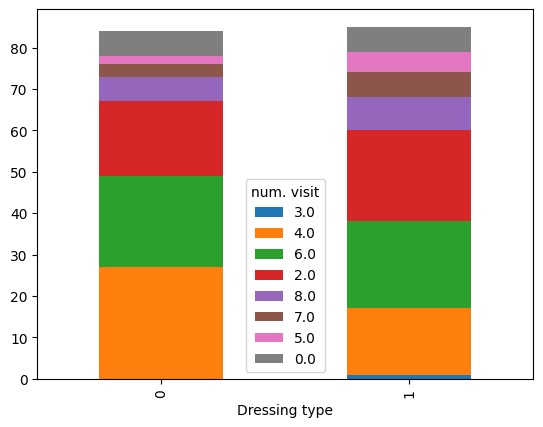

Postural changes: chi-squared p-value = 0.5994485320311351


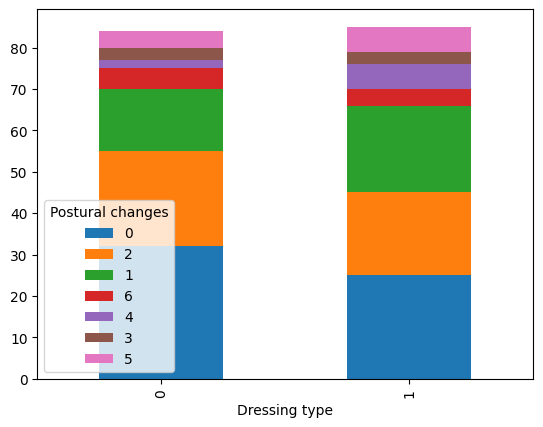

red_friccion: chi-squared p-value = 0.5859594682943616


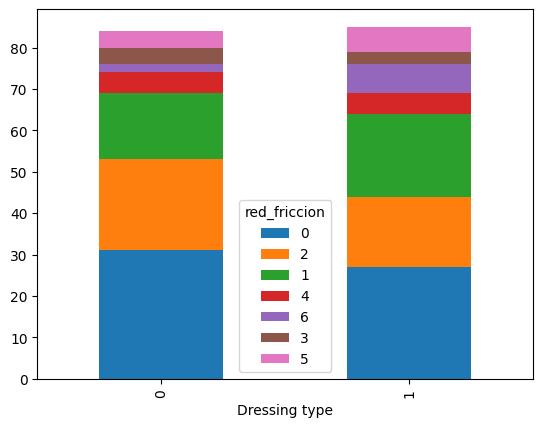

Avoided_infecion: chi-squared p-value = 0.3533445286989254


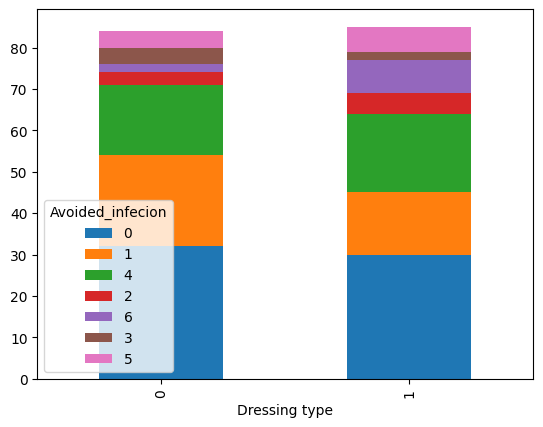

Braden Scale: chi-squared p-value = 0.7005342184910353


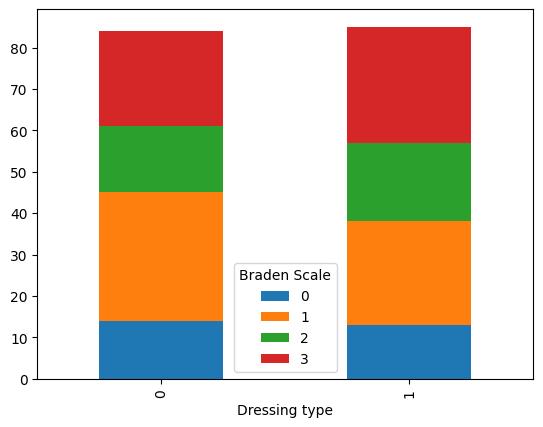

porc_postural changes: chi-squared p-value = 0.22332963843103382


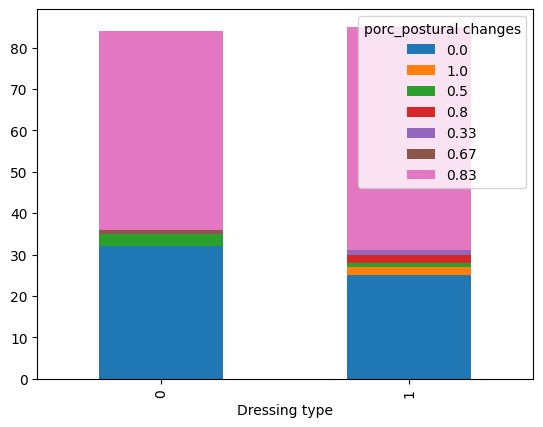

porc_friccion: chi-squared p-value = 0.34498591846374455


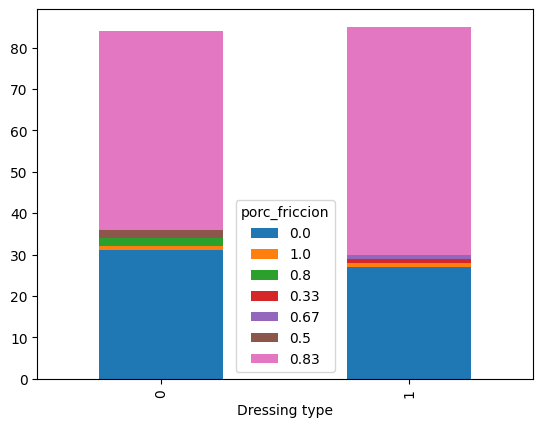

porc_infec: chi-squared p-value = 0.3652607663846712


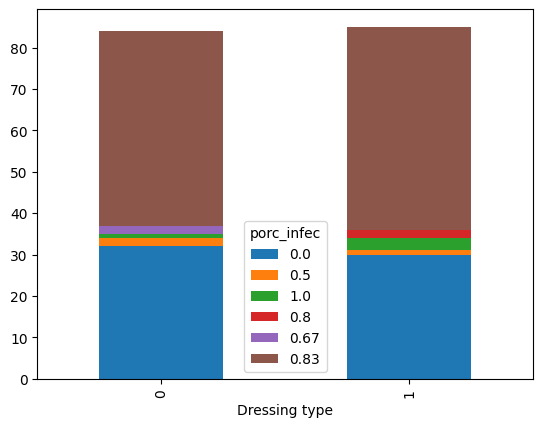

Nurse costs Shapiro-Wilk test results: W = 0.9477, p-value = 0.0000
Nurse costs Mann-Whitney U test p-value: 0.9947



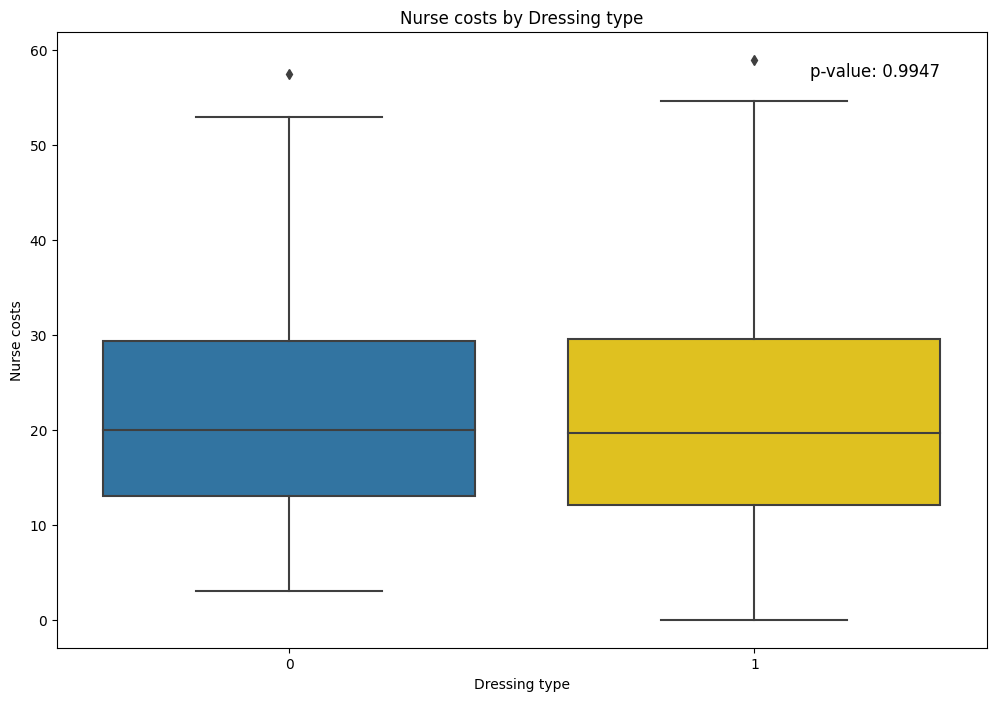

Dressing costs Shapiro-Wilk test results: W = 0.9219, p-value = 0.0000
Dressing costs Mann-Whitney U test p-value: 0.6465



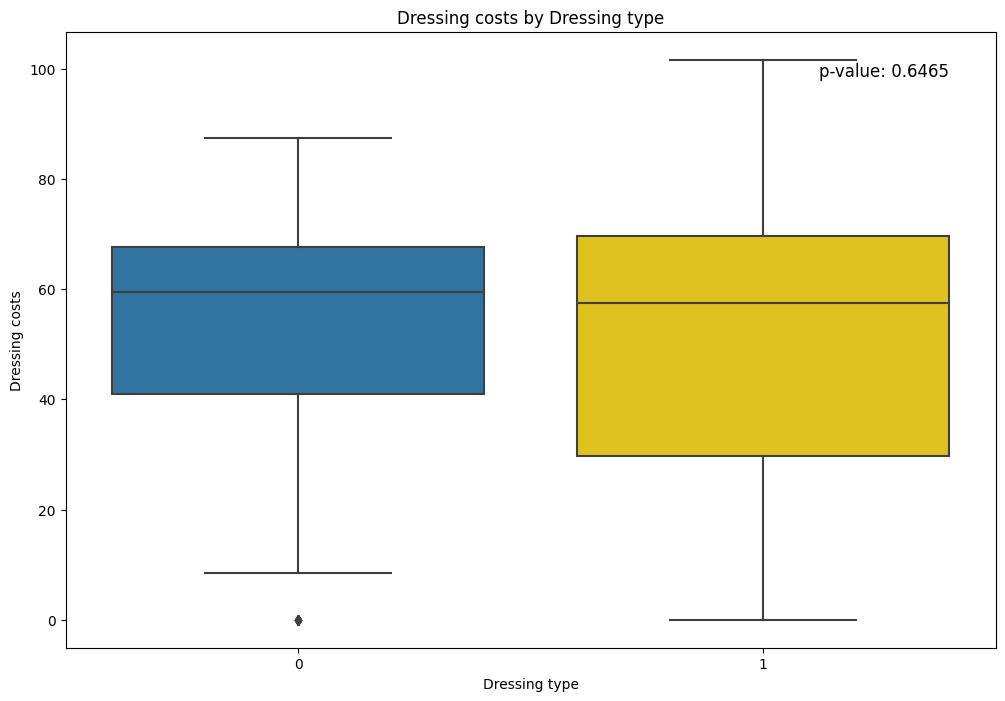

Material costs Shapiro-Wilk test results: W = 0.9384, p-value = 0.0000
Material costs Mann-Whitney U test p-value: 0.5963



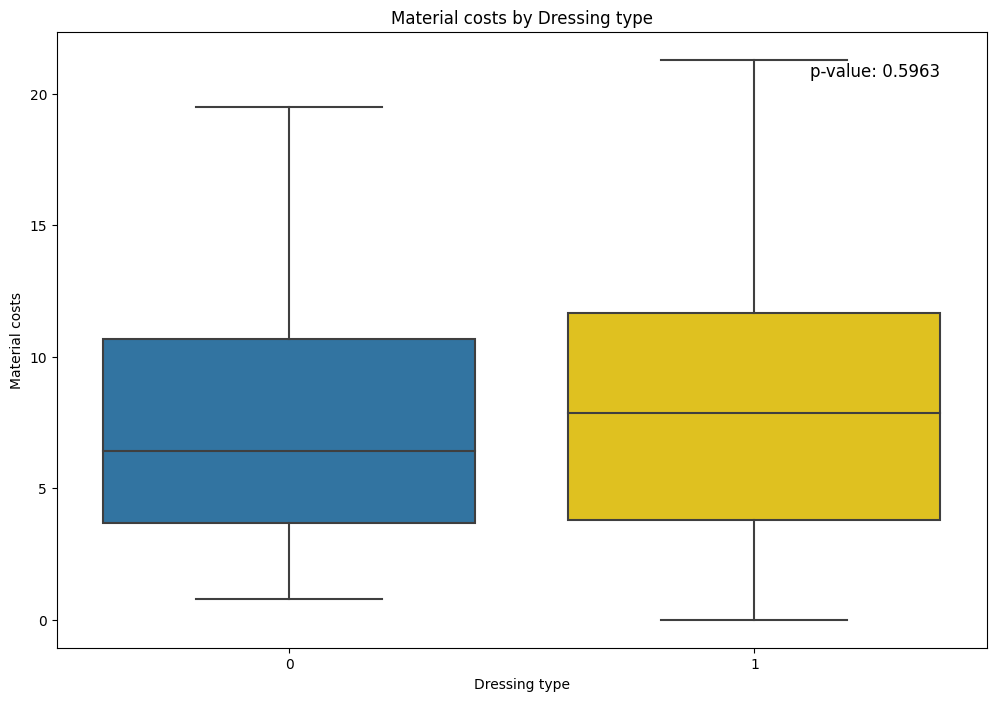

Secondary costs Shapiro-Wilk test results: W = 0.5845, p-value = 0.0000
Secondary costs Mann-Whitney U test p-value: 0.0004



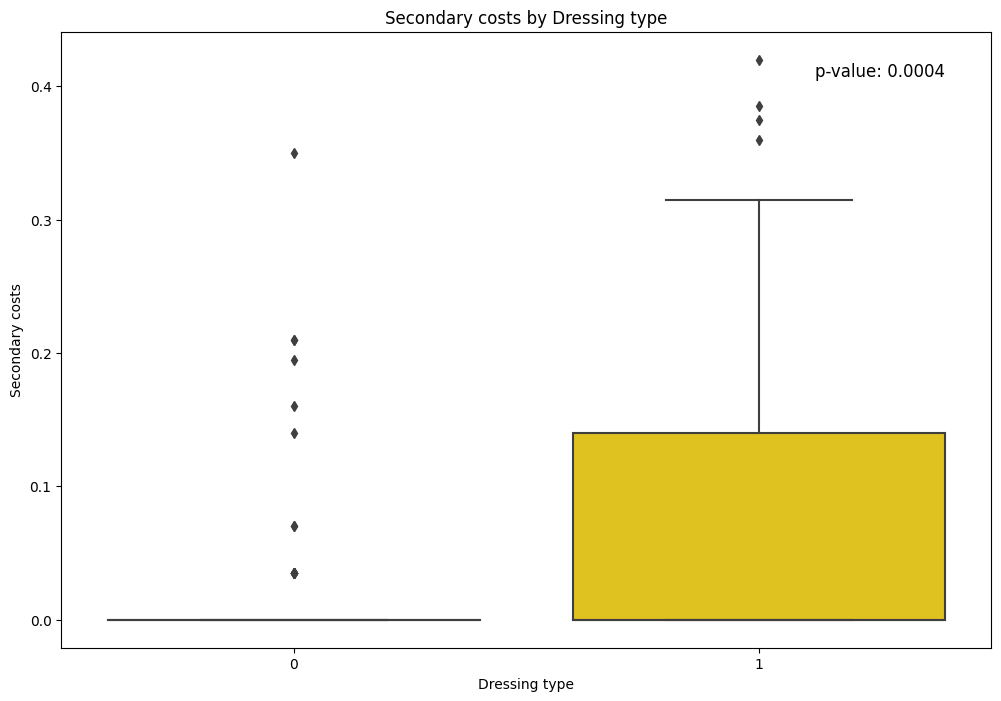

Total costs Shapiro-Wilk test results: W = 0.9907, p-value = 0.3873
Total costs t-test p-value: 0.7726



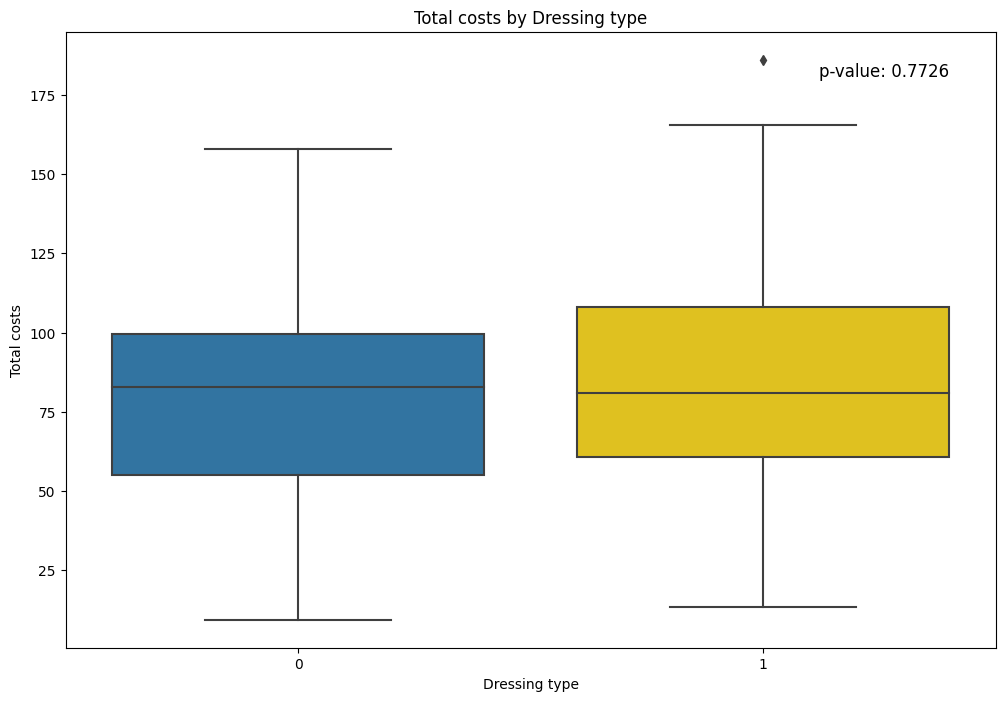

Age Shapiro-Wilk test results: W = 0.9575, p-value = 0.0001
Age Mann-Whitney U test p-value: 0.8287



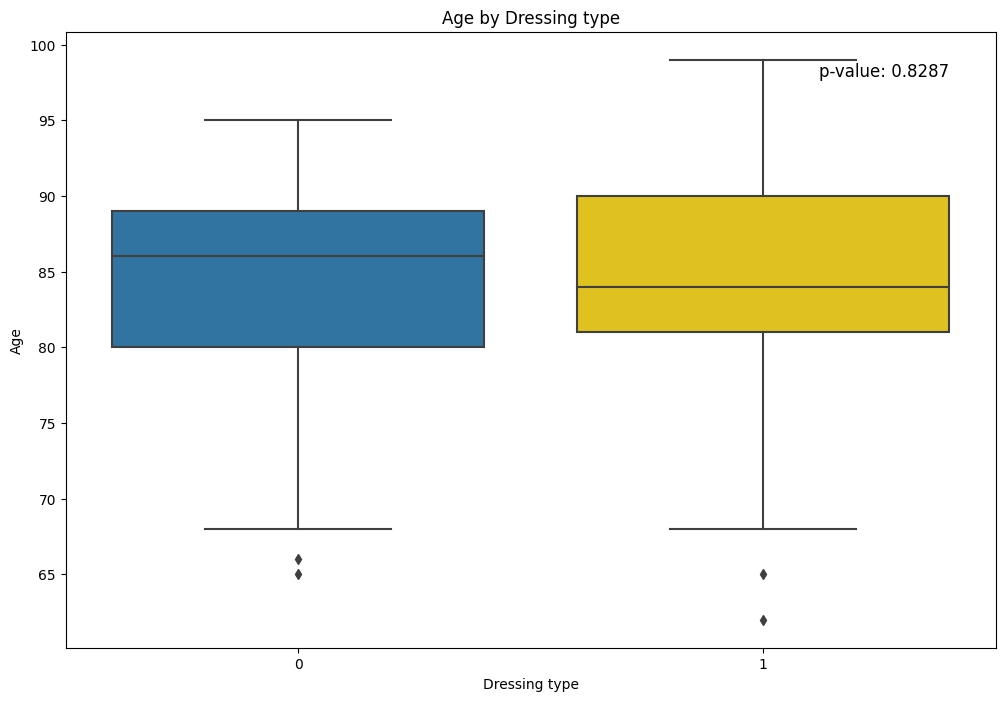

Push Scale Shapiro-Wilk test results: W = 0.9306, p-value = 0.0000
Push Scale Mann-Whitney U test p-value: 0.5420



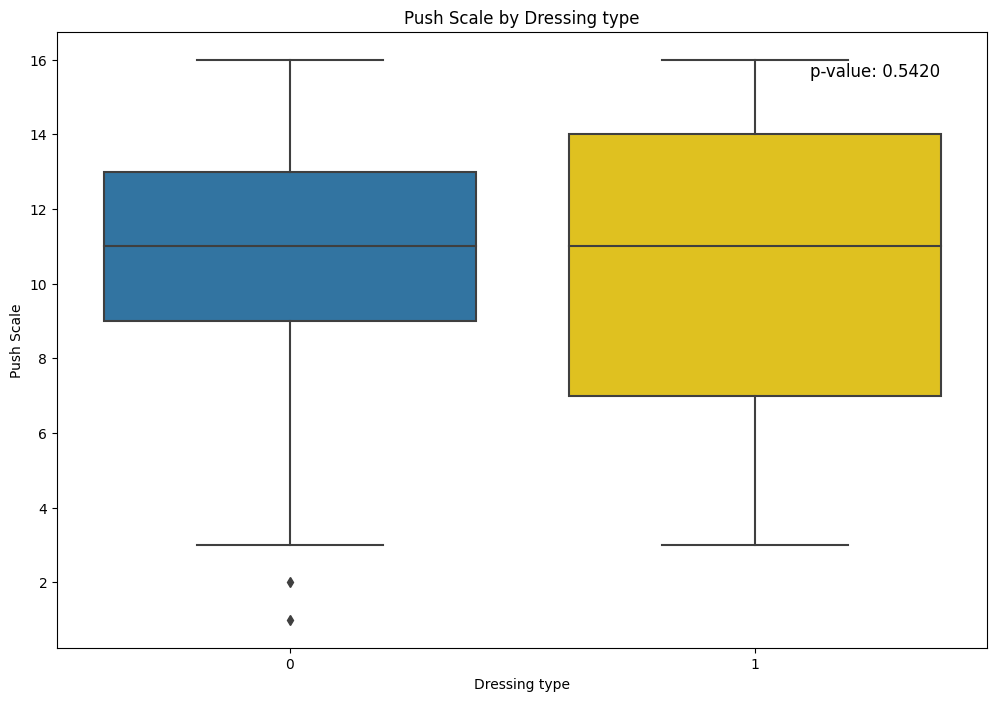

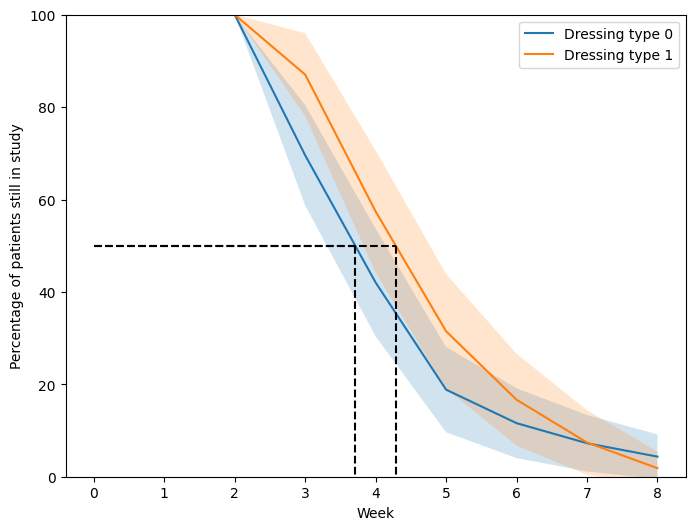

Dressing type 0 confidence intervals:
Week 0: [100.00, 100.00]
Week 1: [100.00, 100.00]
Week 2: [100.00, 100.00]
Week 3: [58.71, 80.42]
Week 4: [30.38, 53.68]
Week 5: [9.61, 28.07]
Week 6: [4.04, 19.15]
Week 7: [1.13, 13.36]
Week 8: [0.00, 9.16]

Dressing type 1 confidence intervals:
Week 0: [100.00, 100.00]
Week 1: [100.00, 100.00]
Week 2: [100.00, 100.00]
Week 3: [78.08, 96.00]
Week 4: [44.22, 70.60]
Week 5: [19.09, 43.87]
Week 6: [6.73, 26.61]
Week 7: [0.42, 14.39]
Week 8: [0.00, 5.45]

Dressing type 0 x value for 50% y-axis: 3.71
Dressing type 1 x value for 50% y-axis: 4.29


Week 0:
T-statistic: nan
P-value: nan
Not significant
Week 1:
T-statistic: nan
P-value: nan
Not significant
Week 2:
T-statistic: nan
P-value: nan
Not significant
Week 3:
T-statistic: -1.7553585752986685
P-value: 0.22128395639173837
Not significant
Week 4:
T-statistic: -1.236023584118563
P-value: 0.34192166635255683
Not significant
Week 5:
T-statistic: -1.1573611703845776
P-value: 0.36667130296259876
Not signif

In [15]:
df = load_and_preprocess_data('/content/drive/My Drive/coste_paciente, per revista.xlsx', '/content/drive/My Drive/datos_analisis2 - english.xlsx')

df = encode_data(df)

visualize_correlation_matrix(df)

binary_columns, discrete_columns, continuous_columns = divide_columns(df)

visualize_binary_columns(binary_columns, 'Dressing type')

visualize_discrete_columns(discrete_columns, 'Dressing type')

visualize_continuous_columns(continuous_columns, 'Dressing type')

plot_percentage_still_in_study(df, 'Dressing type')


DATASET

In [16]:
df

,Nurse costs,Dressing costs,Material costs,Secondary costs,Total costs,Dressing type,Sex,Age,num. visit,Ulcer_stage,...,porc_postural changes,porc_friccion,porc_infec,Loss to follow up,Location_Gluteus,Location_Heel,Location_Malleolus,Location_Other,Location_Sacrum,Location_Trochanter
0,29.250,73.80,8.57600,0.00,111.62600,1,0,91,3.0,1,...,0.0,0.0,0.00,0,0.0,0.0,0.0,0.0,1.0,0.0
1,38.775,73.80,9.66400,0.00,122.23900,1,0,86,4.0,1,...,1.0,1.0,0.50,0,0.0,0.0,0.0,0.0,1.0,0.0
2,15.000,69.70,3.53500,0.00,88.23500,1,0,65,3.0,1,...,1.0,1.0,1.00,0,0.0,0.0,0.0,0.0,1.0,0.0
3,46.250,0.00,8.14000,0.00,54.39000,1,1,81,6.0,2,...,0.5,1.0,1.00,0,0.0,0.0,0.0,0.0,1.0,0.0
4,18.750,57.40,1.68200,0.00,77.83200,1,1,88,2.0,2,...,0.0,0.0,0.00,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,12.500,71.91,6.75600,0.00,91.16600,0,1,73,3.0,1,...,1.0,1.0,1.00,0,1.0,0.0,0.0,0.0,0.0,0.0
165,27.500,0.00,8.99272,0.21,36.70272,0,1,78,3.0,1,...,1.0,1.0,1.00,0,0.0,0.0,0.0,0.0,1.0,0.0
166,7.500,0.00,1.90800,0.00,9.40800,0,0,88,2.0,2,...,0.0,0.0,0.00,1,0.0,0.0,0.0,0.0,1.0,0.0
167,17.500,0.00,4.44400,33.04,54.98400,0,1,91,2.0,1,...,0.0,0.0,0.00,0,0.0,1.0,0.0,0.0,0.0,0.0


CLUSTERING

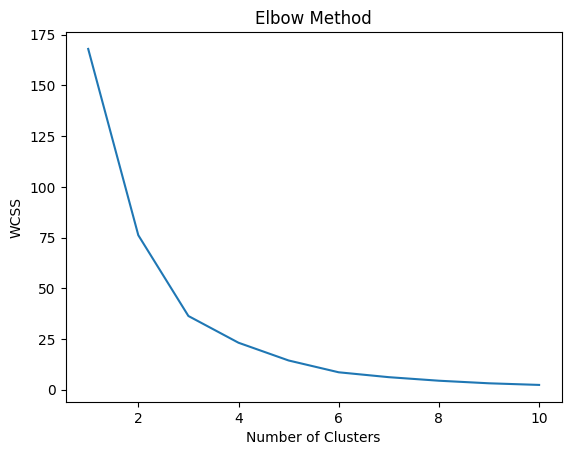

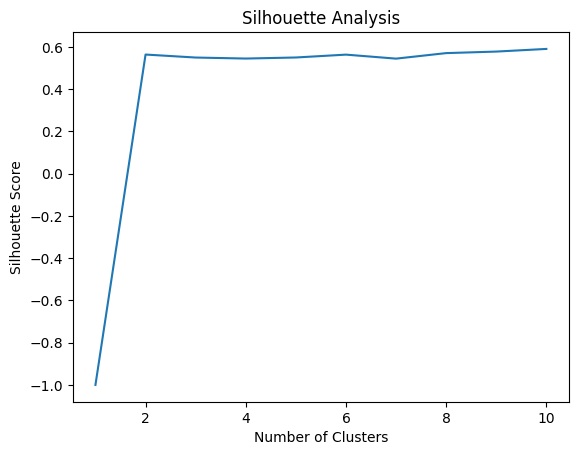

Counts of unique clusters:
1    126
0     43
Name: Cluster, dtype: int64


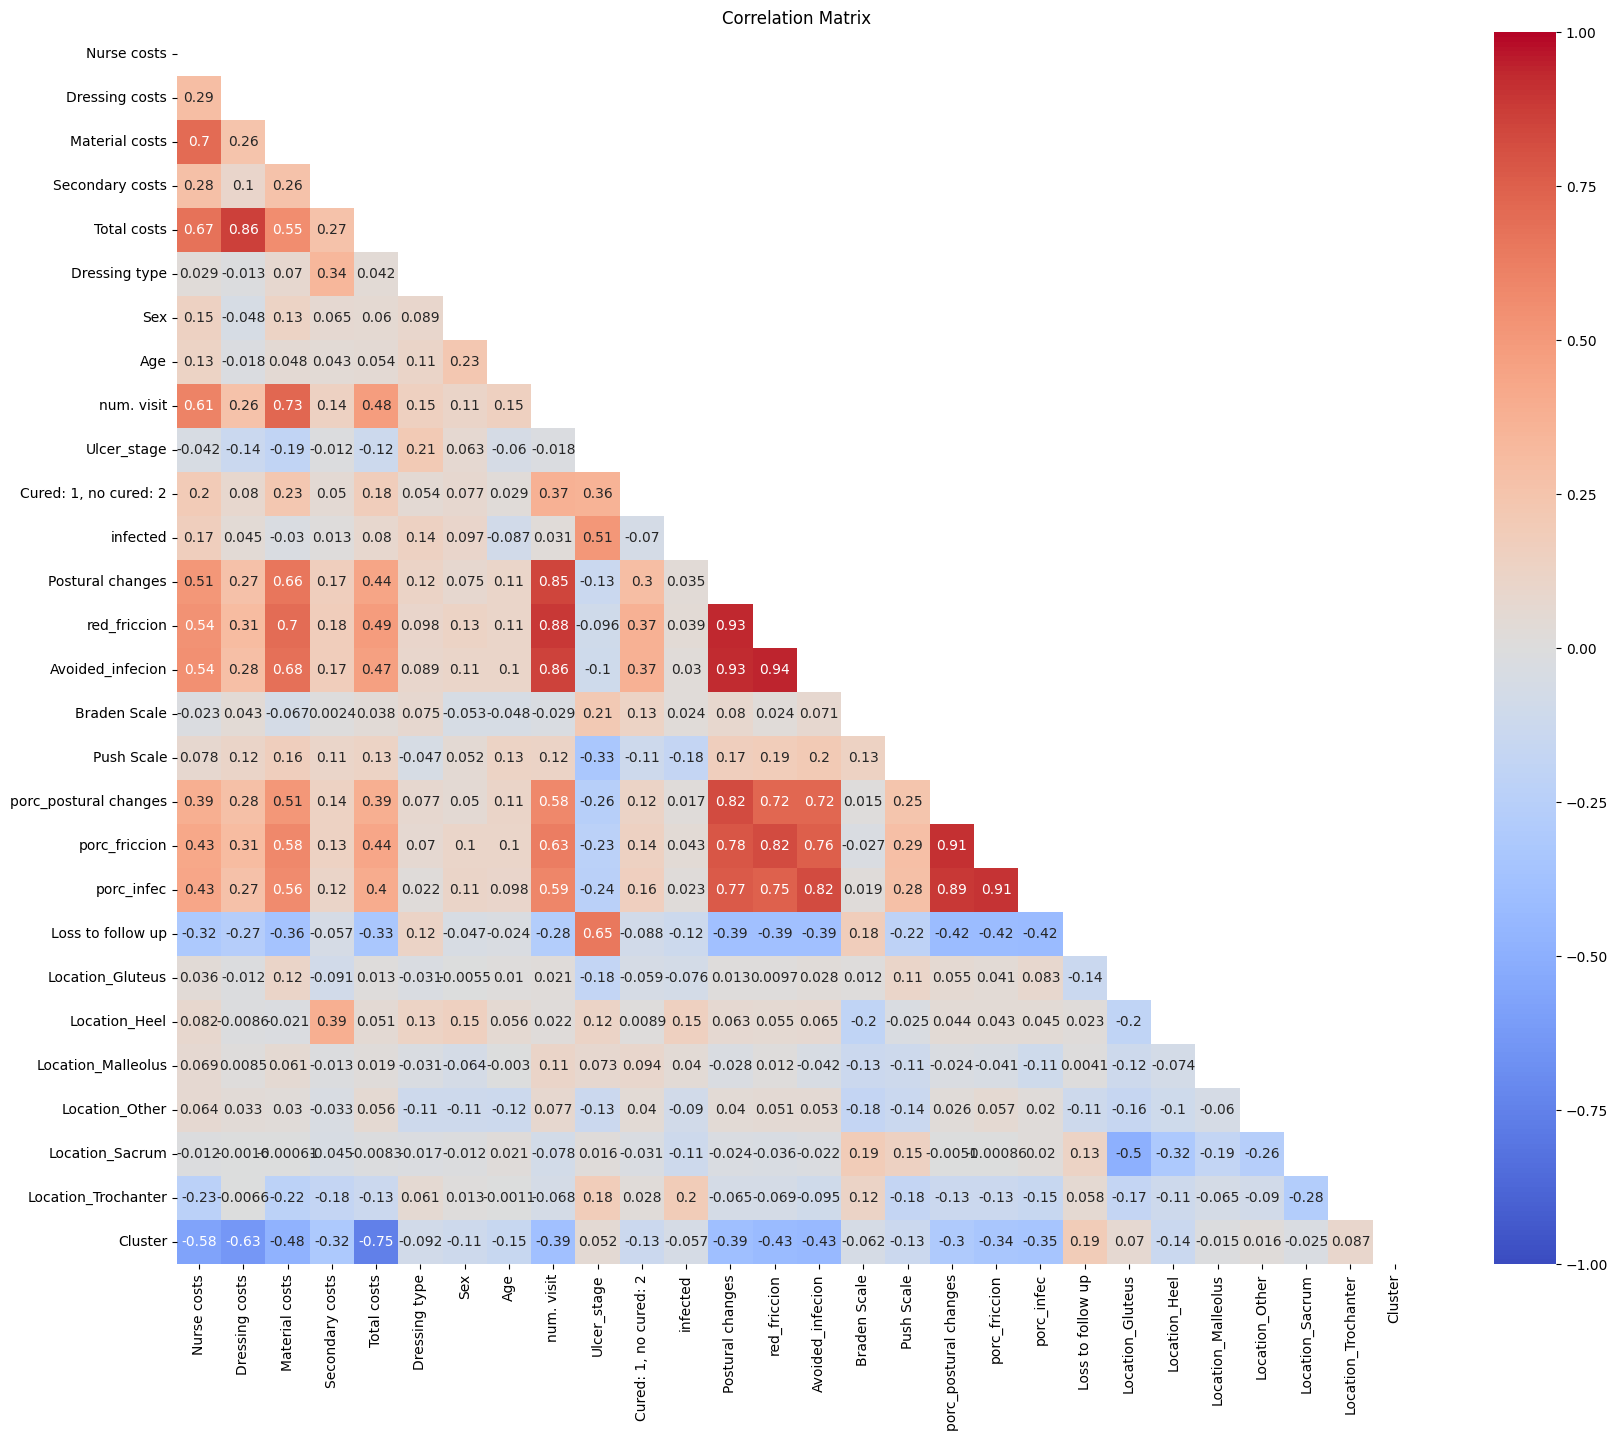

Binary columns: ['Dressing type', 'Sex', 'Ulcer_stage', 'Cured: 1, no cured: 2', 'infected', 'Loss to follow up', 'Location_Gluteus', 'Location_Heel', 'Location_Malleolus', 'Location_Other', 'Location_Sacrum', 'Location_Trochanter', 'Cluster']
Discrete columns: ['num. visit', 'Postural changes', 'red_friccion', 'Avoided_infecion', 'Braden Scale', 'porc_postural changes', 'porc_friccion', 'porc_infec']
Continuous columns: ['Nurse costs', 'Dressing costs', 'Material costs', 'Secondary costs', 'Total costs', 'Age', 'Push Scale']
Dressing type: chi-squared p-value = 0.3102195317314455


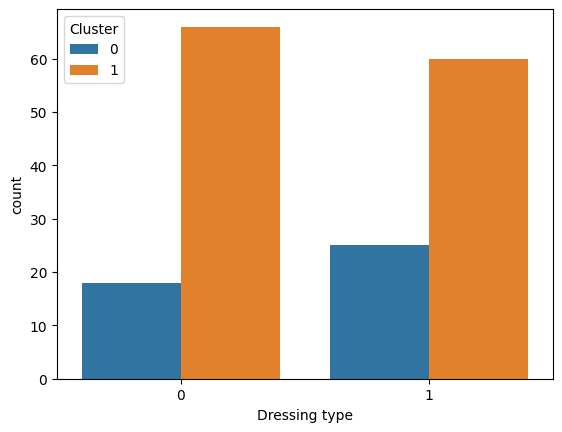

Sex: chi-squared p-value = 0.2020718355746846


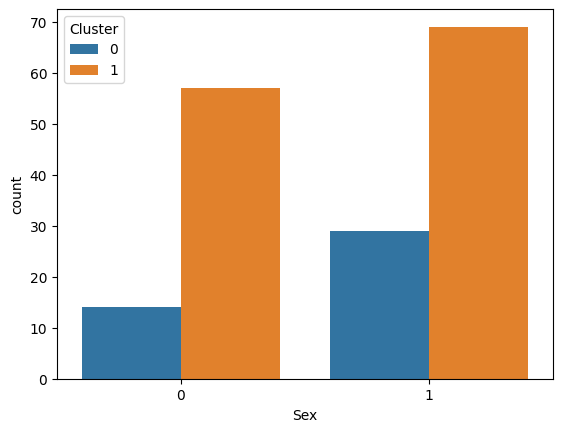

Ulcer_stage: chi-squared p-value = 0.6327842219833213


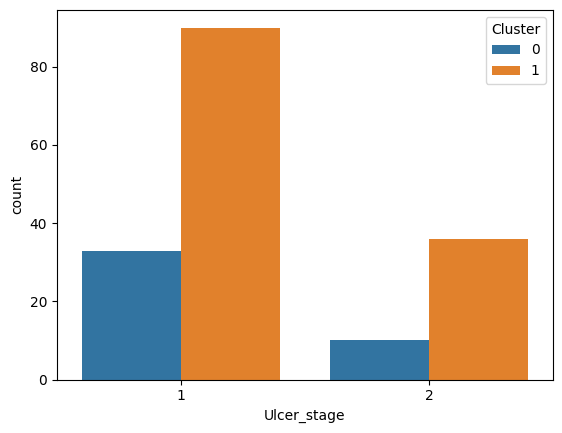

Cured: 1, no cured: 2: chi-squared p-value = 0.2232305427385692


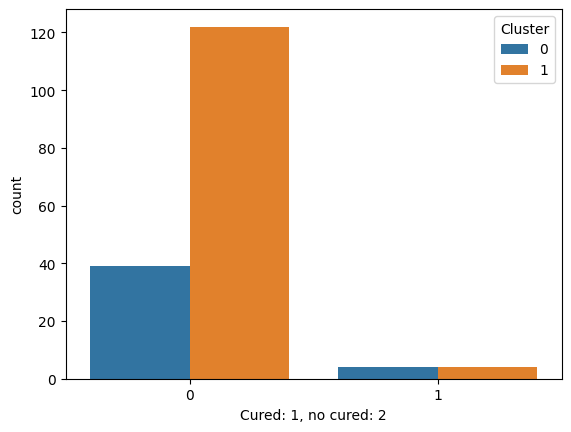

infected: chi-squared p-value = 0.6712566833382597


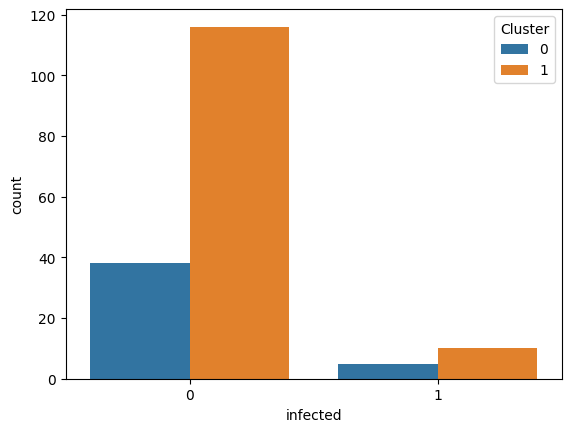

Loss to follow up: chi-squared p-value = 0.024984543230560284


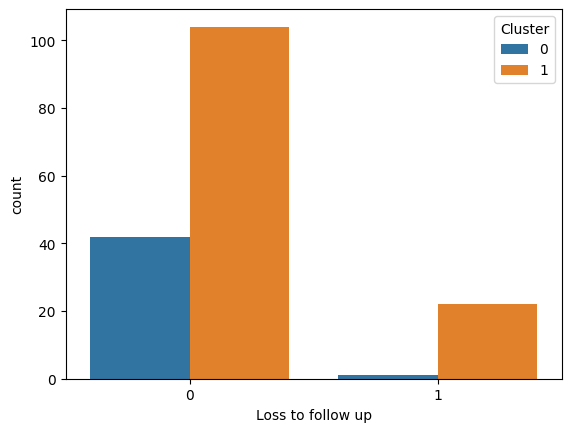

Location_Gluteus: chi-squared p-value = 0.4857834229104564


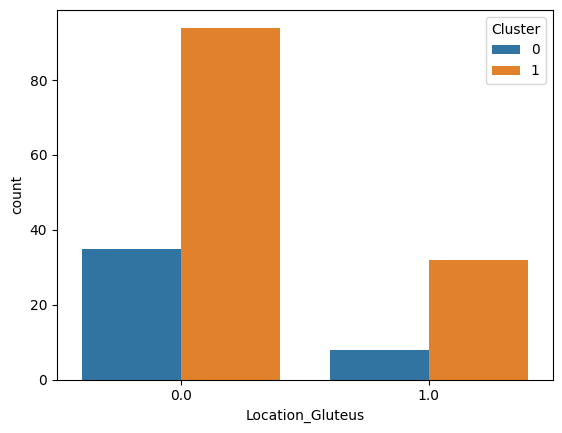

Location_Heel: chi-squared p-value = 0.13612506667769417


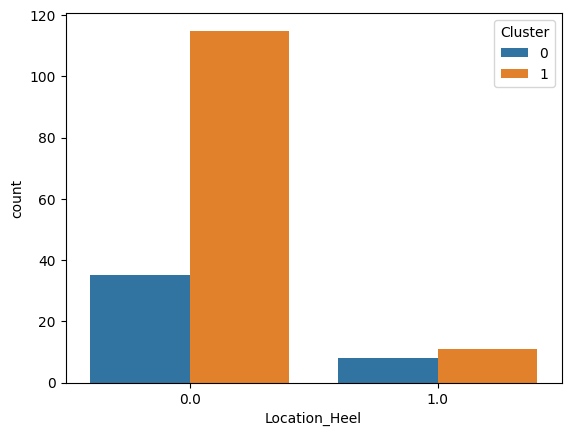

Location_Malleolus: chi-squared p-value = 1.0


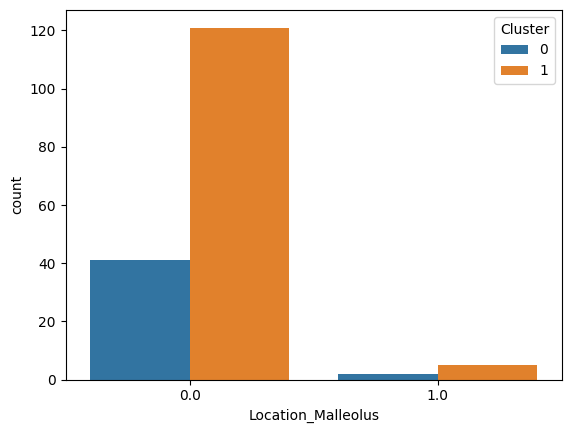

Location_Other: chi-squared p-value = 1.0


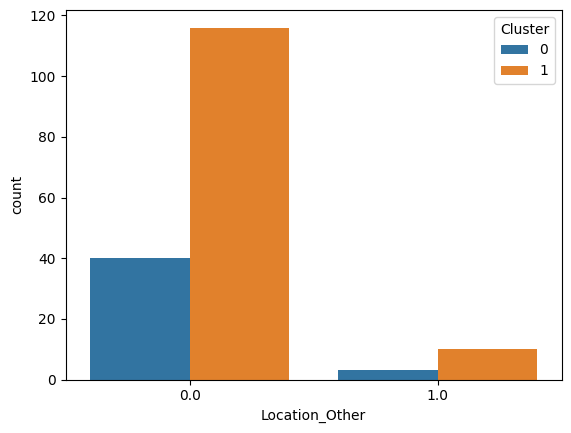

Location_Sacrum: chi-squared p-value = 0.8821121432576176


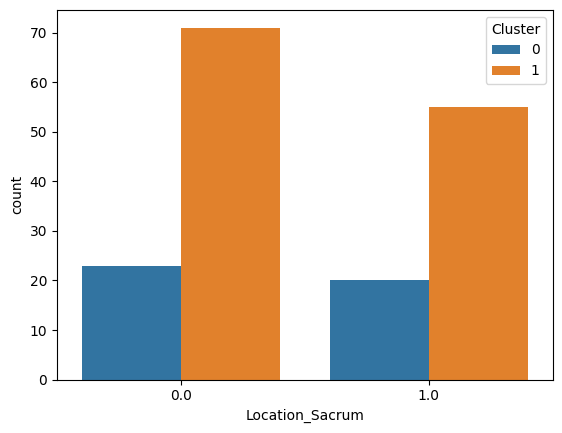

Location_Trochanter: chi-squared p-value = 0.4135781061130037


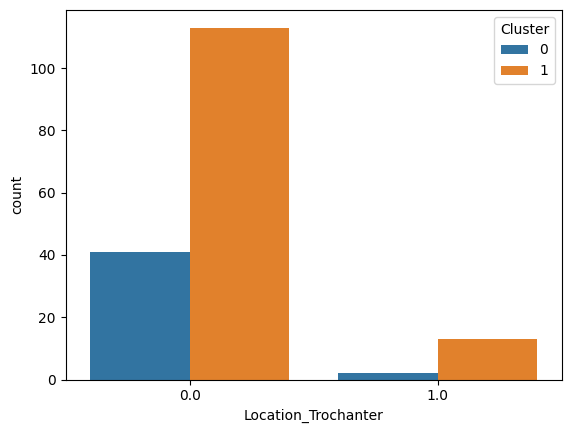

Cluster: chi-squared p-value = 1.6986071173377865e-37


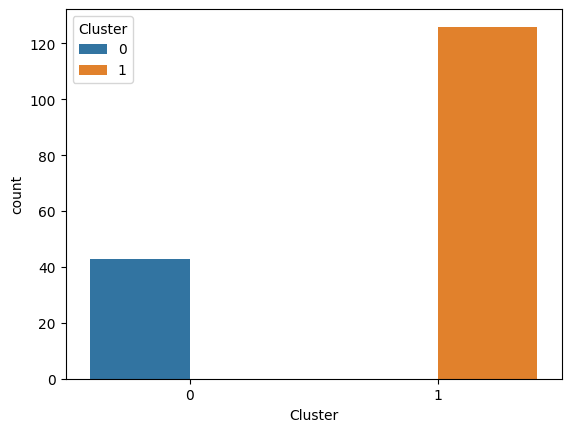

num. visit: chi-squared p-value = 1.2079269551291212e-05


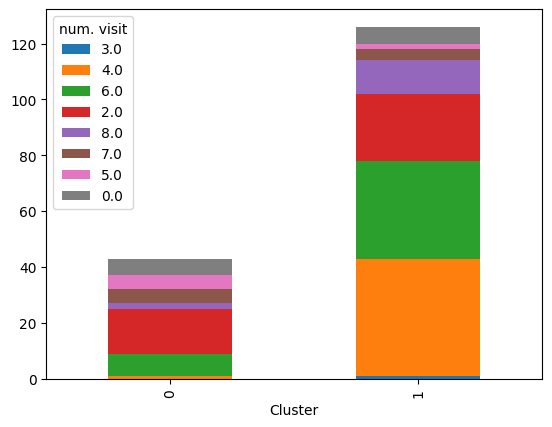

Postural changes: chi-squared p-value = 2.5873947319179165e-06


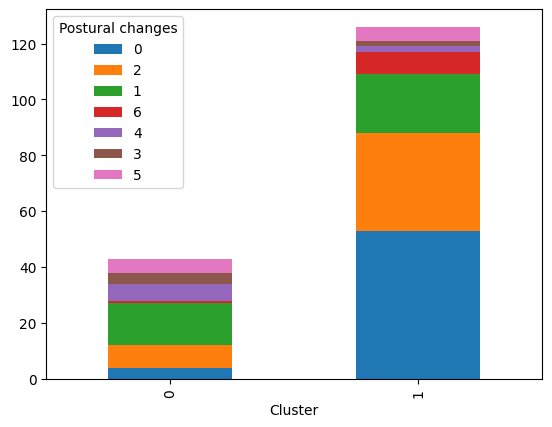

red_friccion: chi-squared p-value = 1.1678995136363374e-06


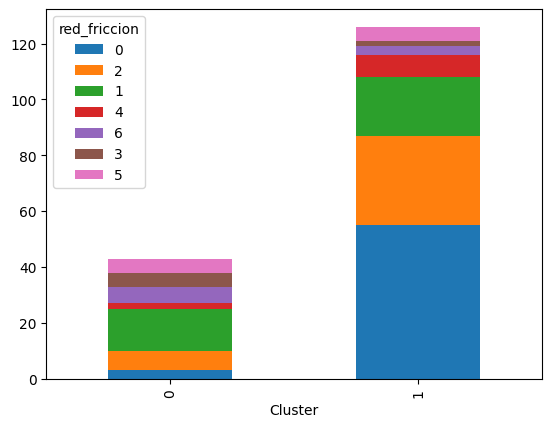

Avoided_infecion: chi-squared p-value = 2.096142582793436e-06


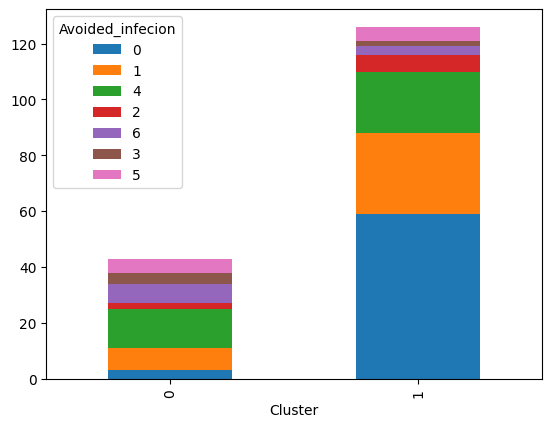

Braden Scale: chi-squared p-value = 0.36358016475677474


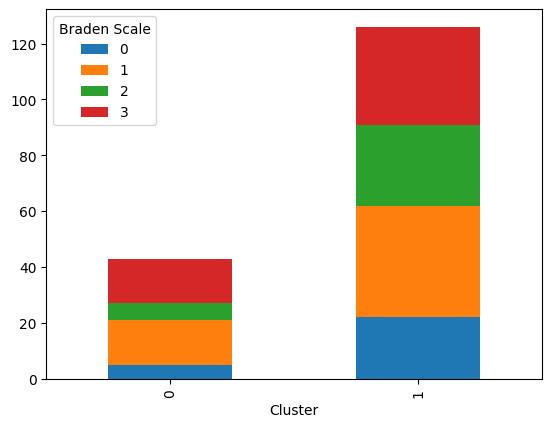

porc_postural changes: chi-squared p-value = 0.002758819918006542


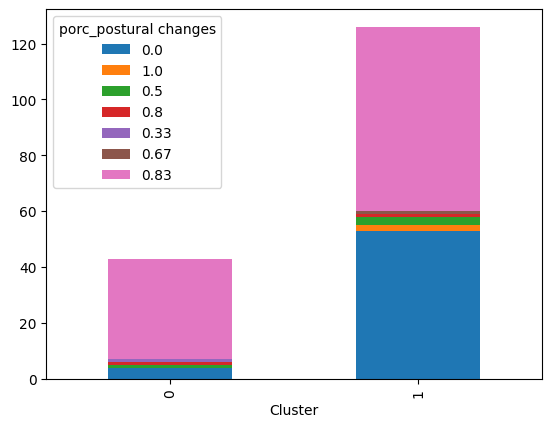

porc_friccion: chi-squared p-value = 0.000348210824308304


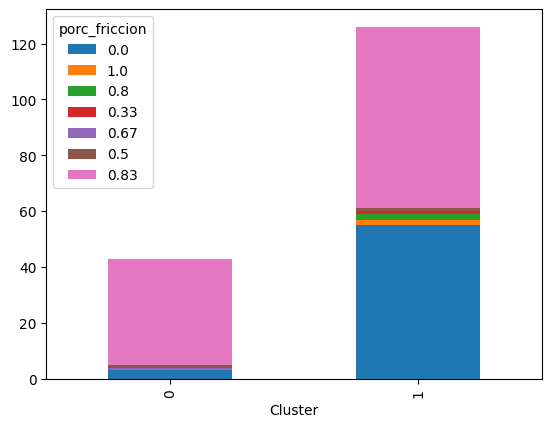

porc_infec: chi-squared p-value = 2.126241874176435e-05


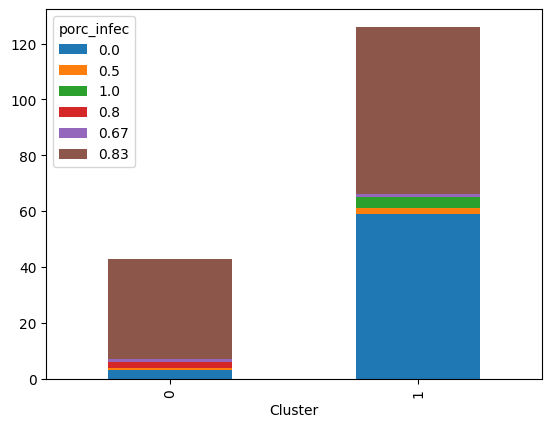

Nurse costs Shapiro-Wilk test results: W = 0.9477, p-value = 0.0000
Nurse costs Mann-Whitney U test p-value: 0.0000



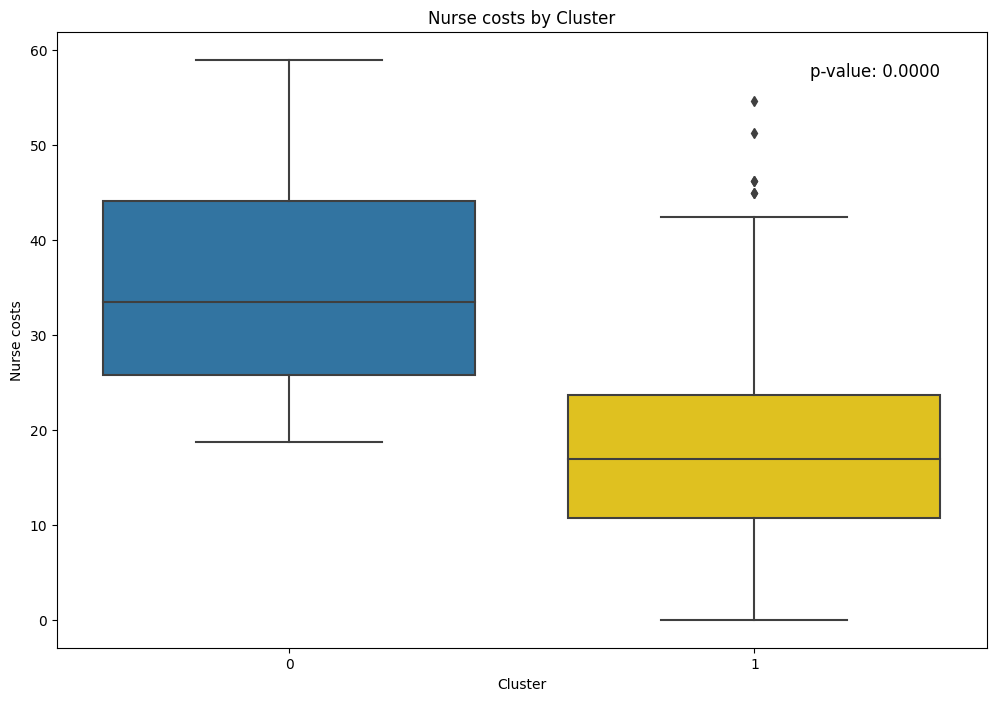

Dressing costs Shapiro-Wilk test results: W = 0.9219, p-value = 0.0000
Dressing costs Mann-Whitney U test p-value: 0.0000



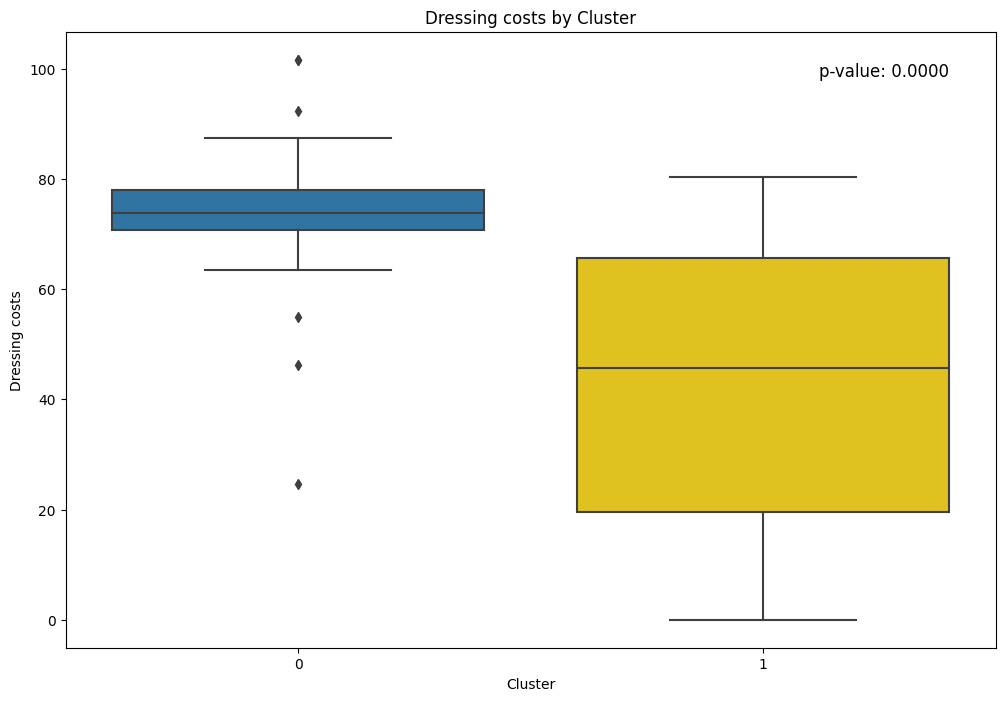

Material costs Shapiro-Wilk test results: W = 0.9384, p-value = 0.0000
Material costs Mann-Whitney U test p-value: 0.0000



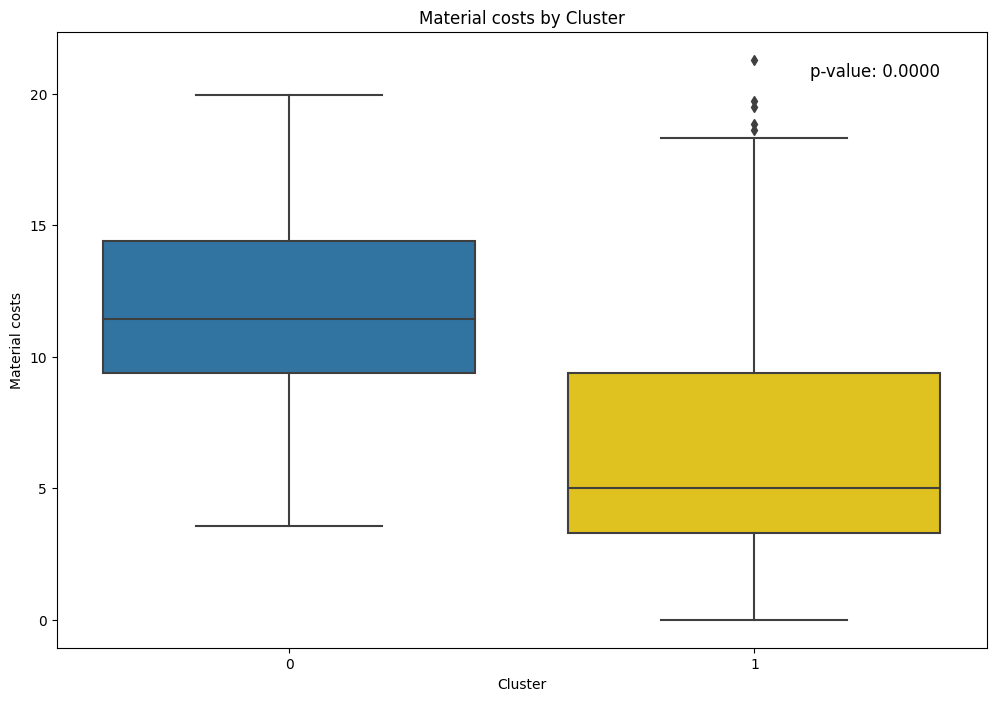

Secondary costs Shapiro-Wilk test results: W = 0.5845, p-value = 0.0000
Secondary costs Mann-Whitney U test p-value: 0.0046



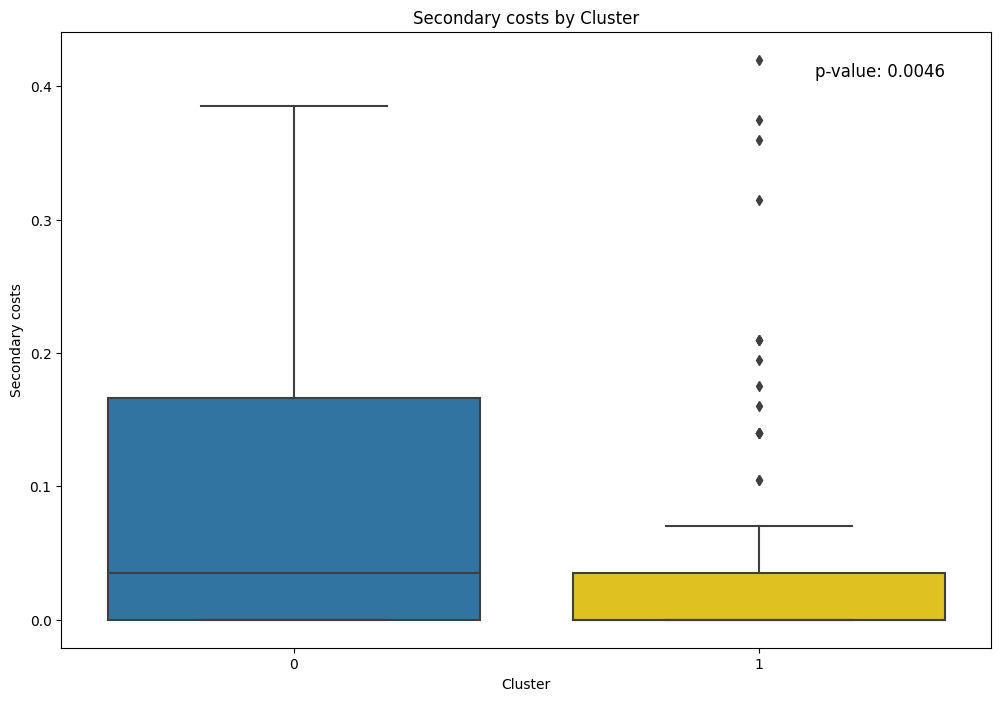

Total costs Shapiro-Wilk test results: W = 0.9907, p-value = 0.3873
Total costs t-test p-value: 0.0000



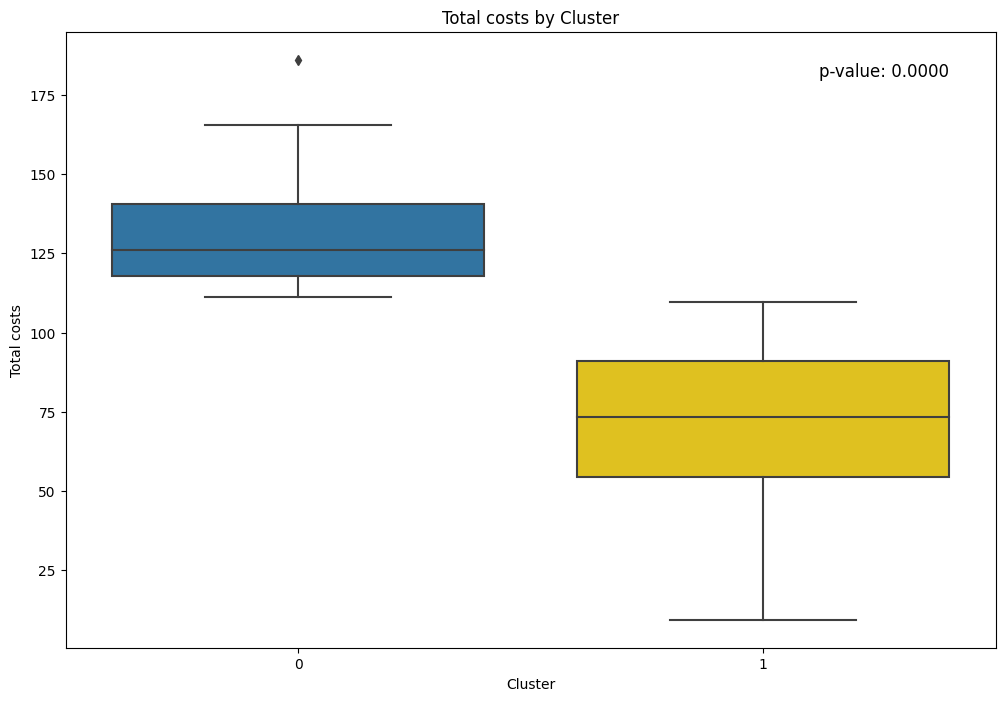

Age Shapiro-Wilk test results: W = 0.9575, p-value = 0.0001
Age Mann-Whitney U test p-value: 0.2534



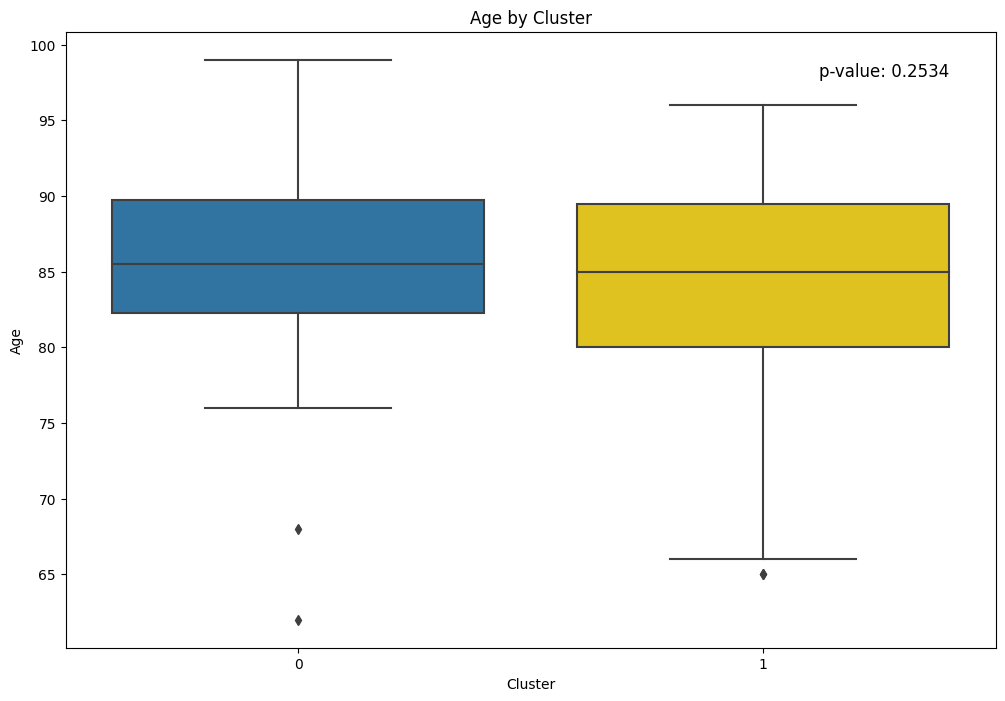

Push Scale Shapiro-Wilk test results: W = 0.9306, p-value = 0.0000
Push Scale Mann-Whitney U test p-value: 0.0993



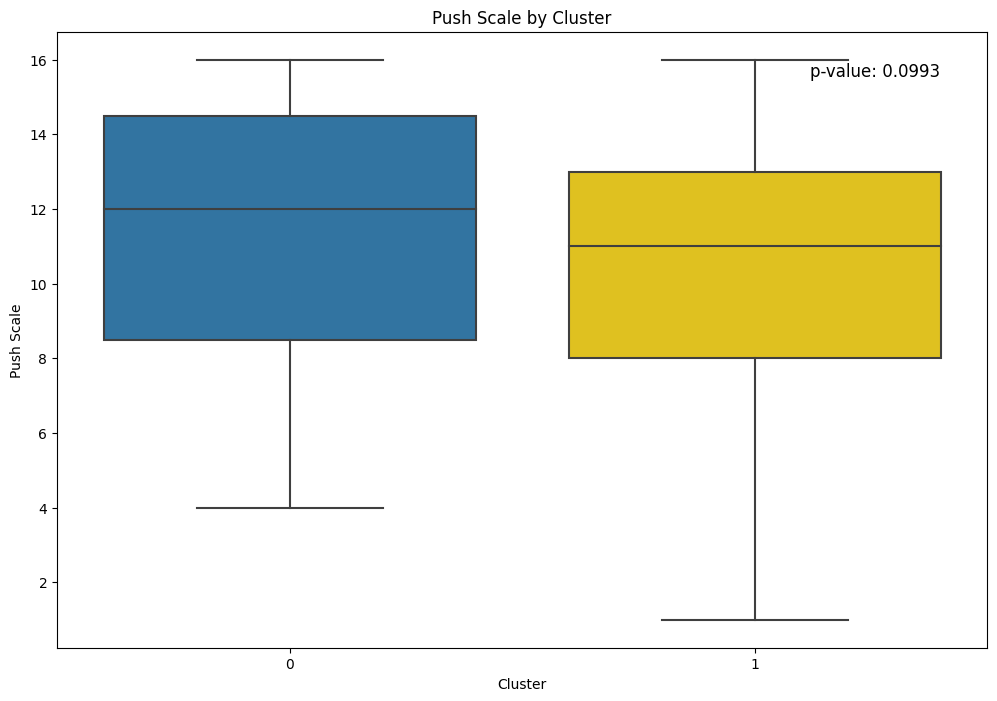

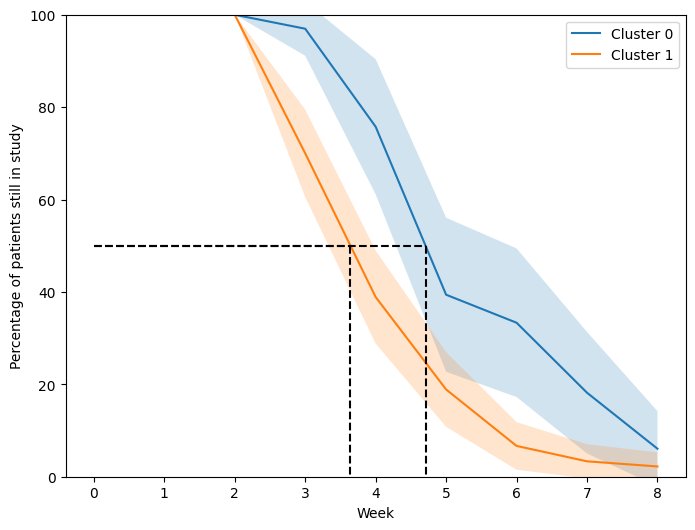

Cluster 0 confidence intervals:
Week 0: [100.00, 100.00]
Week 1: [100.00, 100.00]
Week 2: [100.00, 100.00]
Week 3: [91.12, 100.00]
Week 4: [61.14, 90.38]
Week 5: [22.72, 56.07]
Week 6: [17.25, 49.42]
Week 7: [5.02, 31.34]
Week 8: [0.00, 14.20]

Cluster 1 confidence intervals:
Week 0: [100.00, 100.00]
Week 1: [100.00, 100.00]
Week 2: [100.00, 100.00]
Week 3: [60.53, 79.47]
Week 4: [28.82, 48.96]
Week 5: [10.80, 26.98]
Week 6: [1.51, 11.82]
Week 7: [0.00, 7.04]
Week 8: [0.00, 5.27]

Cluster 0 x value for 50% y-axis: 4.71
Cluster 1 x value for 50% y-axis: 3.64


Week 0:
T-statistic: nan
P-value: nan
Not significant
Week 1:
T-statistic: nan
P-value: nan
Not significant
Week 2:
T-statistic: nan
P-value: nan
Not significant
Week 3:
T-statistic: 3.4568590509974064
P-value: 0.07445716763801598
Significant
Week 4:
T-statistic: 2.9366590608651086
P-value: 0.09903030390807356
Significant
Week 5:
T-statistic: 1.5650155654240057
P-value: 0.25805092261897605
Not significant
Week 6:
T-statistic: 2.23

In [12]:
df = cluster_analysis(df,'Total costs')

visualize_correlation_matrix(df)

binary_columns, discrete_columns, continuous_columns = divide_columns(df)

visualize_binary_columns(binary_columns, 'Cluster')

visualize_discrete_columns(discrete_columns, 'Cluster')

visualize_continuous_columns(continuous_columns, 'Cluster')

plot_percentage_still_in_study(df, 'Cluster')

DISCUSSION

STATISTICAL ANALYSIS

I analyzed the association between the type of Dressing and each single feature present in the dataset. Using the chi2, Wilcoxon test and t-test, the association with Ulcer stage (0.01) and Secondary costs (0.0004) was found to be significant. I found no significant differences in the percentage of patients with healed ulcers from week to week.

CLUSTERING

At this point, I've used K-means, an unsupervised clustering algorithm that is used to cluster data together automatically. I decided to repeat my analysis by dividing the patients into two clusters based on the total cost. The K-means divided the patients into two groups of 126 (Cluster 1) and 43 (Cluster 0). The association with Loss to follow up (0.02) was significant, so patients who disperse are less expensive. This may be because the ulcer heals and patients no longer need to be examined. The association with Number of visits(<0.0001) was significant, probably for the same reason. The association with Postural changes, Red friction and Avoided infection was also significant (<0.0001 for all three). All the cost features are also significant, obviously. It was interesting to see that also the Push Scale (0.09) was significant, higher levels are associated with more expensive treatment. Finally, the period between the third (0.07) and fourth (0.09) week was significant in terms of cost, to the detriment of the most expensive Cluster.

3 MACHINE LEARNING IDEAS

The dataset is undoubtedly very small, so it is difficult to think of a model that can be suitable for classification or regression without incurring overfitting. However, I think that with a higher number of patients, some Machine Learning models able to generalize can be created:

1. A model that investigates which type of dressing works best for different wound types. By analyzing data from different patients, manufacturers could figure out which one works best, and a better product could be created for the needs of doctors and patients.

2. A model that says in which of the eight weeks it would be more appropriate to use one type of dressing or the other. This would help doctors personalize the treatment plan and improve patients' health status.

3. A model that tells which patients are at high risk of having complications would allow patients at risk to be sent to a different hospital ward and avoid wasting resources on ineffective treatments.